## Imports

In [2]:
# BASICS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
# Configurer pandas pour afficher toutes les colonnes
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

#UTILITARIES
from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree

from sklearn import set_config
set_config(display = 'diagram', transform_output= "pandas")

# Sklearn preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler

# Model selection
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
import optuna, optuna_dashboard

#feature selection
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.inspection import permutation_importance

# pipelines
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, FunctionTransformer

# models
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor


link: [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) 
ref score from before: 0.12804



# data Loading

In [3]:
data = pd.read_csv("data/train.csv",index_col="Id" )
#generate a copy to use during EDA
data_exp = data.copy()

# Notebook Structure

## I. EDA (Exploration & Decision Making)
**Goal:** Understand the data and make informed preprocessing decisions WITHOUT modifying the original dataset.
All transformations will be implemented in the Pipeline section.

### 1. Data Overview
   - Dataset info (shape, types)
   - Feature type corrections
   - Count numeric vs categorical features
   - Identify and document useless features


### 2. Duplicates
   - Check and delete for duplicate rows


### 3. Missing Values Analysis
   - Quantify missing values per feature
   - Distinguish "absence" (NA = "None") vs true missing data (domain knowledge)
   - **Decision:** Imputation strategy per feature

### 4. Numerical Features Analysis
   
   a) **Outliers Detection & Removal**
      - Identify extreme outliers (max vs P99)
      - Visualize with boxplots
      - **Action:** Remove aberrant rows NOW (won't be in pipeline)
      - Document removed rows for reproducibility
   
   b) **Skewness Analysis**
      - Calculate skewness for all numerical features
      - Test log transformation effect (before/after comparison)
      - **Decision:** Features requiring log transformation (|skewness| ≥ 1.5)
      - Identify zero-inflated distributions (bimodal)
      - 📝 **Output:** `to_log_transform` list
   
   c) **Distribution & Scaling Strategy**
      - Visualize distributions (histograms, QQ plots)
      - Assess presence of outliers (kurtosis, IQR)
      - **Decision:** Scaler type per feature group
      - 📝 **Output:** `to_minmax`, `to_robust`, `to_standard` lists
   
   d) **Cyclical Features**
      - Identify time-based cyclical features (MoSold)
      - **Decision:** Features requiring sine/cosine transformation
      - 📝 **Output:** `cyclical_features` list
   
   e) **Correlation Analysis**
      - Correlation matrix for numerical features
      - Identify highly correlated pairs (threshold > 0.9)
      - **Decision:** Features to possibly drop at some point due to redundancy

### 5. Categorical Features Analysis
   
   a) **Cardinality Analysis**
      - Count unique values per categorical feature
      - Identify high-cardinality features (> 10 unique values)
   
   b) **Ordinality Identification**
      - Domain knowledge: identify ordinal features (e.g., Quality: Po < Fa < TA < Gd < Ex)
      - Define ordering mappings
      - 📝 **Output:** `ordinal_mappings` dict
   
   c) **Distribution & Rare Categories**
      - Visualize value counts per category
      - Identify rare categories (< 5% threshold)
      - **Decision:** Rare category handling strategy
   
   d) **Encoding Strategy**
      - **Decision:** OneHot, Ordinal, or Target Encoding per feature
      - 📝 **Output:** `to_onehot`, `to_ordinal`, `to_target_encode` lists

### 6. Feature vs Target Relationships
   - Scatter plots: numerical features vs SalePrice
   - Boxplots: categorical features vs SalePrice distribution
   - Correlation with target
   - Identify most predictive features
   - **Insight:** Features to prioritize in feature engineering

### 7. EDA Summary
   - **Comprehensive decision table:** All preprocessing choices in one place
   - Key insights and patterns discovered
   - Warnings and caveats
   - Next steps for pipeline implementation

---

## II. Preprocessing Pipeline Implementation
**Goal:** Implement all EDA decisions in a sklearn pipeline.


### 2. Custom Transformers Definition
- definie the custom transformer (either class if statefull or function transformer if stateless)

### 3. Pipeline Construction
   
   a. **Preprocessing Steps (Sequential)**
      - Drop duplicates (FunctionTransformer)
      - Conditional imputation (Custom Transformer)
      - *Later* Log transformation (FunctionTransformer with `features_to_log`)
      - *Later* Cyclical transformation (FunctionTransformer)
      - *Later* Group rare unique categorical values (Custom Transformer)
   
   b. **Encoding & Scaling (ColumnTransformer)**
      - Ordinal encoding: `to_ordinal` with custom mappings
      - Target encoding: `to_target_encode` (requires y in fit)
      - OneHot encoding: `to_onehot` with handle_unknown='ignore'
      - *Later* MinMax scaling: `to_minmax` (discrete features)
      - *Later* Robust scaling: `to_robust` (continuous with outliers)
      - *Later* Standard scaling: `to_standard` (if needed)
   
   c. **Full Pipeline Assembly**
      - Combine preprocessing + encoding/scaling
  

### 4. Scorer Definition
   - Define RMSLE scorer (custom metric for Kaggle)
   - Define negative RMSLE for GridSearchCV

### 5. Pipeline Testing & Validation
   - Test pipeline on train set


---

## III. Baseline & Model Selection

### 1. Define baseline
- dummy model (predict the average of target price)
- quick and dirty pipeline (no scaling, no encoding, using CatBoost bc handle categorical features natively )

### 2. Base Models Comparison
   - **Linear models:** LinearRegression, Ridge, Lasso, ElasticNet
   - **Tree-based:** RandomForest, XGBoost, CatBoost
   - **Other:** KNN, SVR
   - Cross-validate with preprocessing pipeline
   - Compare RMSLE scores and training times

### 3. Iteration on preprocess
    - Update preprocess step to include the *Later* steps 
    - Rerun CV to update scores

### 4. Select Models
    - Select top 2,3 model based on score

---

## IV. Feature Selection (Optional)

### 1. Variance-Based Selection
   - VarianceThreshold: Remove quasi-constant features

### 2. Importance-Based Selection
   - Feature permutation importance
   - Filter by mean importance and stability
   - Tree-based feature importance (Gini, gain)

### 3. Evaluation
   - Compare scores before/after feature selection
   - Identify most important features

---

## V. Feature Engineering (Optional)

### 1. Engineer features

   - Zero-inflated decomposition (Has_Feature + Feature_log1p)
   - Domain Knowledge - based features. 

### 2. Evaluation
   - Test engineered features with top models
   - Compare scores before/after feature engineering

### 3. Re-Selection
   - If feature count explodes, re-apply feature selection

---

## VI. Hyperparameter Tuning

### 1. Optuna Search

### 2. Final Model Selection
   - Best pipeline with optimal hyperparameters
   - Final CV score

---

## VII. Final Evaluation & Submission

### 1. Train Final Model
   - Train best pipeline on full training set
   - Predict on Kaggle test set



# I. EDA

## I.1 dataset info

In [4]:
print(f"dataset has {data_exp.shape[0]} observations and {data_exp.shape[1]} features")
print("let's consider a max limit of features of 30 for KNN, 100 for SVR, 200 for ridge and lasso, 300 for tree based")

dataset has 1460 observations and 80 features
let's consider a max limit of features of 30 for KNN, 100 for SVR, 200 for ridge and lasso, 300 for tree based


## I.2 Duplicates

In [5]:
duplicates_count = data_exp.duplicated().sum()
print(f"duplicate counts = {duplicates_count}, there are no duplicates")

duplicate counts = 0, there are no duplicates


### Feature info

In [6]:
# Convert MSSubclass into string (arbitrarily encoded categorical feature with no ordinality, to be reeconded later)
data_exp["MSSubClass"] = data_exp["MSSubClass"].astype(str)
num_df = data_exp.select_dtypes(include="number")
cat_df = data_exp.select_dtypes(exclude="number")
print(f" There are {num_df.shape[1]-1} numerical features, including one time feature (month sold) \n There are {cat_df.shape[1]} categorical features")


 There are 35 numerical features, including one time feature (month sold) 
 There are 44 categorical features


#### Feature Quality
- **No intrinsically useless features**: No IDs, URLs
- Variable predictive power: Some features likely have **low impact** on SalePrice 
  (e.g., Utilities, Street may have quasi-zero variance)
--> *VarianceThreshold and feature selection* will handle 
  

#### Feature Types
- Numeric and Categorical and 1 temporal. Type error already handled.
- Some categorical features have **high cardinality**. 
- Some categorical features have ordinality.  

#### Temporal Features
- **Year-based features**: YearBuilt, YearRemodAdd, GarageYrBlt, YrSold
- Transformation: *Will convert to ages* (House_Age, Years_Since_Remod, Garage_Age) 
  in preprocessing for:
  - Better interpretability (30 years vs 1994)
  - Temporal consistency across predictions

#### Conditional Features & Missing Values
- Logical structure: **Many features depend on others**:
  - Garage features (7) exist only if house has garage
  - Basement features (9) exist only if house has basement
  - Pool, Fireplace, Fence features similarly conditional

- **Missing values semantics**: 
  - NA often **means absence**, not true missing data_exp
  - Example: `GarageType = NA` means "no garage", not "unknown garage type"

- **Imputation strategy** (to be detailed in Missing Values section):
  - Categorical conditionals: NA → 'None' (indicating absence)
  - Numerical conditionals: NA → 0 (no area/count)
  - Temporal conditionals: GarageYrBlt → Garage_Age with median imputation
  - True missing values: domain-appropriate methods (median, mode, or predictive)




## I.3 Missing Values

### Cases where "NA" means "absence of characteristics

For those categorical features: impute "None"


In [7]:
# missing value count
missing_value = data_exp.isna().sum().sort_values(ascending= False)/len(data_exp)*100
missing_value[missing_value > 0]

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageCond       5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtCond         2.534247
BsmtQual         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64

In [8]:
#list of categorical feature where "NA" means absence as per documentation
col_to_impute_na = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
                    "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC",
                    "Fence", "MiscFeature"]

#filling NA meaning absence of characteristic with "None"
data_exp[col_to_impute_na] = data_exp[col_to_impute_na].fillna("None")

### Case of veneer features

Still high number of MasVnrType (60%), not counted as "absence "in the documentation. Need to investigate whether these are real missing values.

- inspection of data_exp[["MasVnrType", "MasVnrArea"]] looks like MasVnrType that are NA are also with Area 0, so it doesnt seem missing at random. 

#### Analysis of NA, None, and 0 values for veneer type and area

In [9]:
# ===================
# missing data in VENEER AREA
# ===================
# number of NA-area houses
print(f"there are {len(data_exp[data_exp["MasVnrArea"].isna()])} houses with veneer area is NaN")
#number of 0-area houses
#house with no veneer (area = 0)
print(f" there are {len( data_exp[data_exp["MasVnrArea"] == 0])} houses with Vnr area = 0 \n")
# number of houses that are both NA-area and NA-type

#===================
# missing data in VENEER TYPE
#===================
#number of NA-type houses
print(f"there are {len(data_exp[data_exp["MasVnrType"].isna()])} NA-type houses")
#number of None-type houses
print(f" there are {len( data_exp[data_exp["MasVnrType"] == 'None'])} None-type houses \n")

#=========
# Patterns
#=========

# area = 0 & type = NA
print(f"Houses with area = 0, type = NA: {len( data_exp[ (data_exp["MasVnrArea"] == 0) & (data_exp["MasVnrType"].isna())])}")
print(f"representing {len(data_exp[ (data_exp["MasVnrArea"] == 0) & (data_exp["MasVnrType"].isna())] )/len( data_exp[data_exp["MasVnrArea"] == 0])}% of 0-area houses")
print(f"representing {len(data_exp[ (data_exp["MasVnrArea"] == 0) & (data_exp["MasVnrType"].isna())] )/len( data_exp[data_exp["MasVnrType"].isna()])}% of NA-type houses")
#area = 0 & type != NA
print(f"Houses with area = 0, type != NA: {len( data_exp[ (data_exp["MasVnrArea"] == 0) & (data_exp["MasVnrType"].notna())])}")
#area  != 0 & type = NA
print(f"Houses with area > 0, type = NA: {len( data_exp[ (data_exp["MasVnrArea"] > 0) & (data_exp["MasVnrType"].isna())])}")
#area > 0 and type != NA (normal)

#area = NA & type != NA
print(f"Houses with area = NA, type != NA : {len(data_exp[(data_exp['MasVnrType'].notna()) & (data_exp['MasVnrArea'].isna())])}")
#area = NA & type = NA
print(f"Houses with area = NA, type = NA: {len(data_exp[  data_exp["MasVnrArea"].isna() & data_exp["MasVnrType"].isna()])}")


there are 8 houses with veneer area is NaN
 there are 861 houses with Vnr area = 0 

there are 872 NA-type houses
 there are 0 None-type houses 

Houses with area = 0, type = NA: 859
representing 0.9976771196283392% of 0-area houses
representing 0.9850917431192661% of NA-type houses
Houses with area = 0, type != NA: 2
Houses with area > 0, type = NA: 5
Houses with area = NA, type != NA : 0
Houses with area = NA, type = NA: 8


#### Conclusions and imputing strategy



No `'None'` values exist in `MasVnrType`, despite documentation specifying this as the standard encoding for absence of veneer.

- **859 houses**: `Area=0` and `Type=NA` (99.8% of zero-area houses and 98.5% of NA-type houses)
- **5 houses**: `Area>0` and `Type=NA` 
- **8 houses**: Both `Area=NA` and `Type=NA`
- **2 houses**: `Area=0` but `Type≠NA` (logical inconsistency)

If `Type=NA` represented true missing values, NAs would be distributed across all area values. Instead, they are concentrated where `Area=0`, indicating **`NA` implicitly encodes "no veneer"**. 

The 8 houses with both features NA likely represent true missing values (both features not collected), rather than dual encoding errors.

| Pattern | Count | Action | Rationale |
|---------|-------|--------|-----------|
| Area=0, Type=NA | 859 | Set `Type='None'` | Correct implicit encoding for absence |
| Area = 0, Type != NA | 2 | Drop rows | Logical inconsistency|
| Area > 0, Type = NA | 5 | Impute Mode | Likely true missing `Type` value  |
| Area = NA, Type = NA | 8 | Impute `Type` with mode and `Area` with mode | Likely missing values |

**Note**: For "both NA" cases, we impute conservatively with median area and mode type (calculated among houses with veneer), as these likely represent missing data_exp rather than absence. The imputation with mode should be done before encoding of "NA" into "None" otherwise "None" will be counted as the mode for this distribution. 





In [10]:
# drop rows where area = 0 and type != NA (unsolvable inconsistency)
row_to_drop = data_exp.loc[(data_exp["MasVnrType"].notna()) & (data_exp["MasVnrArea"] ==0), :].index
data_exp = data_exp.drop(index = row_to_drop)

# Impute mode for rows where area > 0 and type = NA (missing value)
type_mode = data_exp["MasVnrType"].mode()[0]
data_exp.loc[(data_exp["MasVnrArea"] > 0) & data_exp["MasVnrType"].isna(), "MasVnrType"] = type_mode

#impute Type mode and Area median for rows where area = NA and type = NA
area_median = data_exp["MasVnrArea"].median()
fill_values = {"MasVnrArea": area_median, "MasVnrType" : type_mode}
data_exp.loc[data_exp["MasVnrArea"].isna() & data_exp["MasVnrType"].isna(),["MasVnrType", "MasVnrArea"]] = data_exp.loc[data_exp["MasVnrArea"].isna() & data_exp["MasVnrType"].isna(),["MasVnrType", "MasVnrArea"]].fillna(value= fill_values)

# impute Type to "None" when Type is NA and area is 0
data_exp.loc[(data_exp["MasVnrType"].isna()) & (data_exp["MasVnrArea"] ==0), "MasVnrType"] = 'None'

### Handling LotFrontage and Electrical features

- roughly 6% of NA in electrical. Not an encoding of absence pas per documentation, and a house without electrical installation is unlikely --> consider as real NA and impute mode of the distribution. 

- LotFrontage, 17% of NA. Again, not encoding an absence as per documentation. Here again, rather unlikely to have a house unconnected to street. --> impute median

In [11]:
# Handling electrical
data_exp.loc[data_exp["Electrical"].isna(), "Electrical"] = data_exp["Electrical"].mode()[0]

#Handling LotFrontage missing data_exp
data_exp.loc[data_exp["LotFrontage"].isna(), "LotFrontage"] = data_exp["LotFrontage"].median()

### Handling of GarageYrBlt 

**Pattern observed**: All 73 houses with `GarageYrBlt=NA` also have other garage features indicating absence (`GarageType=NA`, `GarageArea=0`, etc.).

**Interpretation**: `NA` represents "no garage" (logical absence), not missing data.

**Handling strategy**: 
1. Convert all year features to ages (e.g., `GarageYrBlt` → `Garage_Age`)
2. Create binary indicator `Has_Garage` (0 = no garage, 1 = has garage)
3. For houses without garage: impute `Garage_Age` with median (calculated among houses with garages)

**Rationale**: 
- Cannot calculate age for non-existent garage 
- Median imputation provides neutral value that won't bias the model
- `Has_Garage` explicitly captures presence/absence
- Because it requires to transform numerical features (year), this missing value imputing step will be done during the Numerical Feature inspection part of EDA. 



In [12]:
# missing value count
missing_value = data_exp.isna().sum().sort_values(ascending= False)/len(data_exp)*100
missing_value[missing_value > 0]

GarageYrBlt    5.555556
dtype: float64

## I.4 Inspect Numerical Features


### Handling age conversion and garage age NA

In [13]:
year_features = ["GarageYrBlt", "YrSold","YearBuilt", "YearRemodAdd"]
#calculate house age at sell time
data_exp["House_age"] = data_exp["YrSold"] - data_exp["YearBuilt"]
# Add binary "remodelling" feature: 1 if remodelled, 0 if not
data_exp["Was_remodelled"] = (data_exp["YearRemodAdd"] != data_exp["YearBuilt"]).astype(int)

# Calculate remodelling age
data_exp["Remodelled_age"] = data_exp["YrSold"] - data_exp["YearRemodAdd"]

# Add binary "has garage" feature: 0 if no garage, 1 if garage
#data_exp["Has_garage"]  = (data_exp["GarageYrBlt"]).notna().astype(int)

# Age of garage (will remain NA in absence of garage)
data_exp["Garage_age"] = data_exp["YrSold"] - data_exp["GarageYrBlt"]

#impute median garage age for rows where "Garage_age" = NA (meaning no garage)
median_garage_age = data_exp.loc[data_exp["GarageYrBlt"].notna(), "Garage_age"].median()
data_exp["Garage_age"] = data_exp["Garage_age"].fillna(value= median_garage_age)

data_exp = data_exp.drop(columns= year_features)

#update list of numerical features
num_df = data_exp.select_dtypes(include="number")


### Inspect outliers


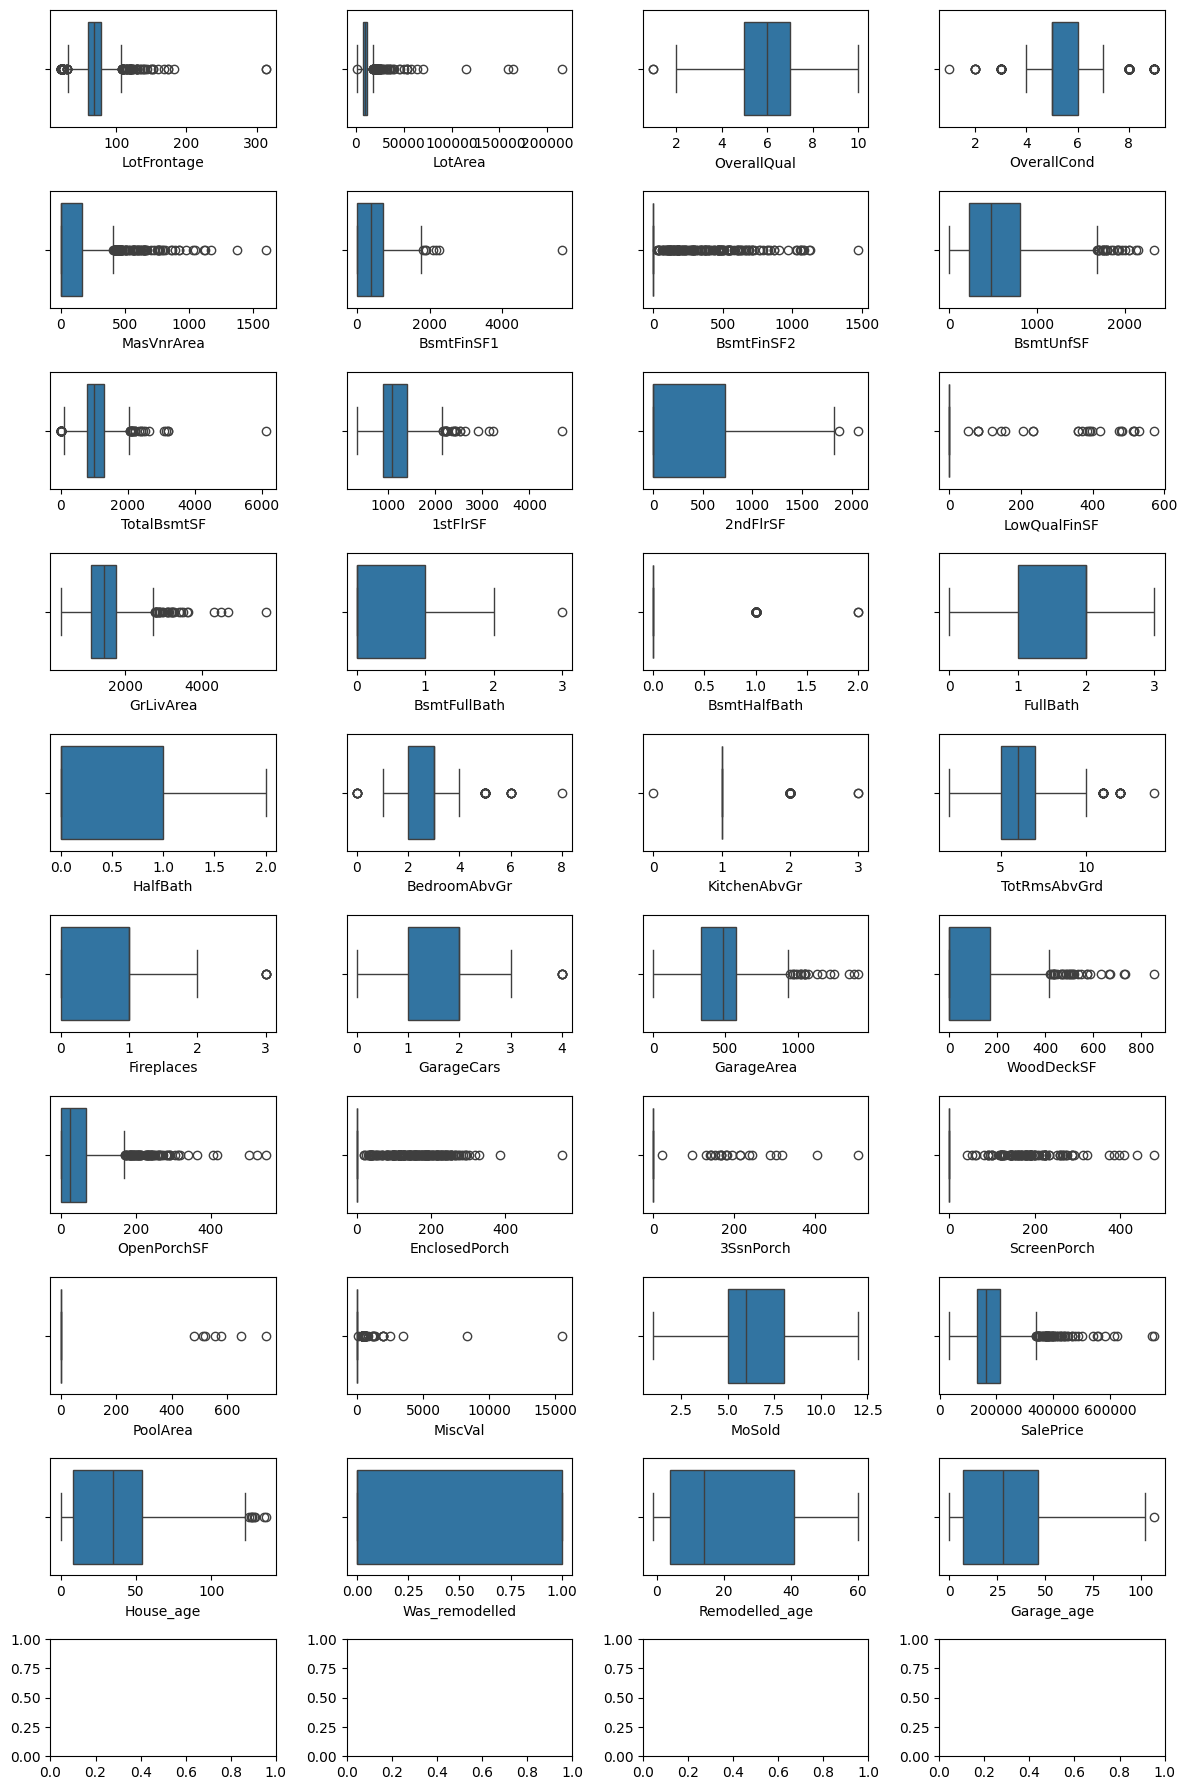

In [14]:
#box plot and outliers
fig, axes = plt.subplots(10,4, figsize = (12,18))
axes = axes.flatten()
for idx, feature in enumerate(num_df.columns):
    axes[idx] = sns.boxplot(x= data_exp[feature], ax= axes[idx])

plt.tight_layout()
plt.show()

Some outliers are strongly detached from the rest. Consider removal. Let's inspect better by looking at spread between max and 99 percentile

In [15]:
# Check which features show a gap between max value and 99-percentile value
data_exp.describe(percentiles=[0.90, 0.95, 0.99])

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,House_age,Was_remodelled,Remodelled_age,Garage_age
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,69.861454,10518.951303,6.097394,5.574760,103.258573,443.600137,46.613169,566.534979,1056.748285,1162.089849,347.468450,5.852538,1515.410837,0.425240,0.057613,1.564472,0.383402,2.866941,1.046639,6.517147,0.613169,1.766118,472.585734,94.277778,46.685871,21.984225,3.414266,15.081619,2.762689,43.548697,6.319616,180730.190672,36.598080,0.477366,22.981481,29.273663
std,22.038589,9987.895073,1.382847,1.113452,180.814962,456.073916,161.420729,441.185107,438.591599,386.548397,436.638462,48.655960,525.815190,0.518929,0.238907,0.551058,0.503030,0.816014,0.220483,1.626410,0.644829,0.747104,213.565518,125.394752,66.289760,61.155666,29.337173,55.792877,40.204743,496.460799,2.703751,79284.550497,30.240565,0.499659,20.637282,24.024607
min,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,34900.000000,0.000000,0.000000,-1.000000,0.000000
50%,69.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,0.000000,477.500000,991.000000,1086.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,2.000000,479.500000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,163000.000000,35.000000,0.000000,14.000000,28.000000
90%,92.000000,14395.100000,8.000000,7.000000,335.000000,1066.500000,117.600000,1229.200000,1602.000000,1680.000000,954.600000,0.000000,2158.900000,1.000000,0.000000,2.000000,1.000000,4.000000,1.000000,9.000000,1.000000,3.000000,756.300000,262.000000,130.000000,112.000000,0.000000,0.000000,0.000000,0.000000,10.000000,277650.000000,84.000000,1.000000,56.000000,61.000000
95%,104.000000,17403.450000,8.000000,8.000000,456.000000,1274.000000,396.600000,1460.350000,1753.000000,1831.750000,1141.150000,0.000000,2466.300000,1.000000,1.000000,2.000000,1.000000,4.000000,1.000000,10.000000,2.000000,3.000000,846.600000,335.000000,175.150000,180.450000,0.000000,160.000000,0.000000,0.000000,11.000000,325680.400000,91.000000,1.000000,58.000000,78.000000
99%,137.430000,37619.720000,10.000000,9.000000,791.440000,1572.430000,830.740000,1797.150000,2155.150000,2219.580000,1419.160000,360.000000,3124.040000,2.000000,1.000000,3.000000,1.000000,5.000000,2.000000,11.000000,2.000000,3.000000,1003.170000,505.580000,285.860000,261.150000,168.000000,268.150000,0.000000,700.000000,12.000000,442692.230000,110.430000,1.000000,60.000000,90.000000
max,313.000000,215245.000000,10.000000,9.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,755000.000000,136.000000,1.000000,60.000000,107.000000


Focusing on continous data, some features show a gap between max and 99 percentile, especially LotFrontage, LotArea, BsmtFinSF1, TotalBsmtSF, MiscVal. Let's check the top 20 values for them. 


In [16]:
#Check top 20 values
possible_outliers = [ "LotArea", "BsmtFinSF1", "TotalBsmtSF", "MiscVal"]
outliers_dict = {}

for feat in possible_outliers:
    sorted_values = data_exp[feat].sort_values(ascending= False)
    #reset index and drop, to allow concatenating all series in one df
    outliers_dict[feat] = sorted_values.reset_index(drop= True).values

outlier_df = pd.DataFrame(outliers_dict)
outlier_df.head(20)

#miscval and LotArea are the weirdest, and possibly BsmtFinSF1, TotalBsmtSF

,LotArea,BsmtFinSF1,TotalBsmtSF,MiscVal
0,215245,5644,6110,15500
1,164660,2260,3206,8300
2,159000,2188,3200,3500
3,115149,2096,3138,2500
4,70761,1904,3094,2000
5,63887,1880,2633,2000
6,57200,1810,2524,2000
7,53504,1767,2444,2000
8,53227,1721,2396,1400
9,53107,1696,2392,1300


The 1st-ranked is clearly separated from the rest for these 4 features. Let's check if it's aberrant. 

In [17]:
features_of_interest = ["LotArea",	"BsmtFinSF1",	"TotalBsmtSF",	"MiscVal"]
top_house_dict = {}

for feat in features_of_interest :
    max_idx = data_exp[feat].idxmax()
    #retrive the feature values for the house with the max value for the feature on interest
    top_house_dict[f"{feat}_max"] = data_exp.loc[max_idx]

top_house_df = pd.DataFrame(top_house_dict)
top_house_df

,LotArea_max,BsmtFinSF1_max,TotalBsmtSF_max,MiscVal_max
MSSubClass,20,60,60,20
MSZoning,RL,RL,RL,RL
LotFrontage,150.0,313.0,313.0,69.0
LotArea,215245,63887,63887,12772
Street,Pave,Pave,Pave,Pave
Alley,None,None,None,None
LotShape,IR3,IR3,IR3,IR1
LandContour,Low,Bnk,Bnk,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub
LotConfig,Inside,Corner,Corner,CulDSac


- LotArea max: seems ok: just a large terrain with a smaller house. 
- Bsmt features: a bit weird: sale price at the median, while it has a pool. 2nd floor SF much smaller than 1st floor, and basement even larger. Overall quality 10, apparently new (house age = 0). Doesnt really make sense with the house price. let's remove. 
- MiscVal: logical because it has a second garage. 

In [18]:
# REMOVAL ABERRANT HOUSE
#check that we have just one house in this condition
(data_exp["TotalBsmtSF"] == 6110).sum()
#drop it
data_exp = data_exp[data_exp["TotalBsmtSF"] != 6110]

### Inspect skewness and transform

#### Distribution

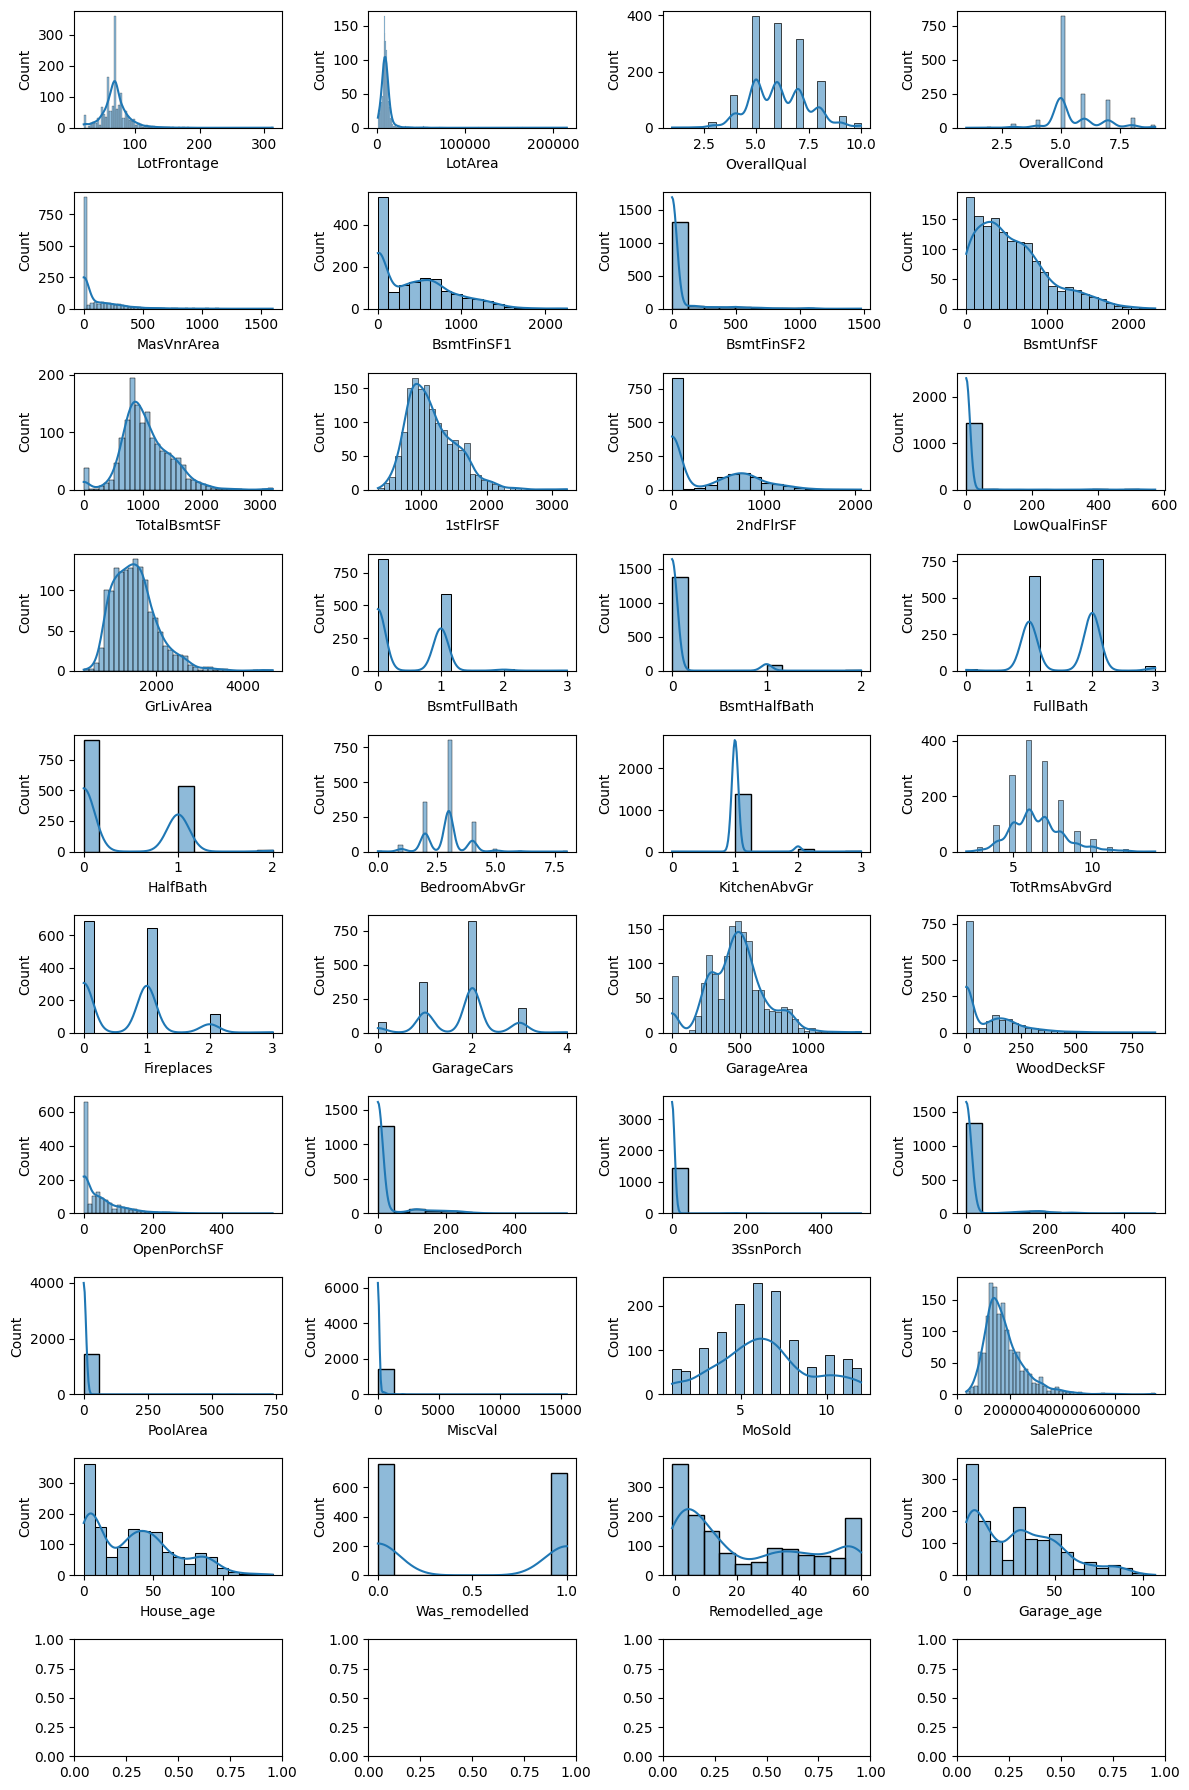

In [19]:
#distribution

fig, axes = plt.subplots(10,4, figsize = (12,18))
axes = axes.flatten()
for idx, feature in enumerate(num_df.columns):
    axes[idx] = sns.histplot(x= data_exp[feature], kde= True, ax= axes[idx])

plt.tight_layout()
plt.show()

#### Skewness

- Help to decide on the necessity of feature transformation (log). 
- we'll use usual threshold: transformation if skewness above 1.5, and consider transformation for skewness between 0.5 and 1. 


In [20]:
skewness = data_exp[num_df.columns].skew().sort_values(ascending= False)


#### Log Transformation

**Objective:** Reduce skewness in numerical features to improve model performance, particularly for linear models.

**Methodology:**
1. Selection criteria: Apply log transformation to features with `|skewness| ≥ 1.5`
   - Threshold rationale: Global compromise suitable for both linear models (Ridge, Lasso, LinearReg) and tree-based models (XGBoost, RandomForest, CatBoost)
   - Features with `|skewness| < 1.5` are considered sufficiently symmetric

2. **Exclusions from transformation:**
   - Discrete/count features: (e.g., `KitchenAbvGr`, `BsmtHalfBath`) → Log transformation inappropriate for discrete values; will be handled with MinMaxScaler to preserve sparsity and distance
   - Target variable: (`SalePrice`) → Will be handled separately with dedicated strategy

3. **Transformation method:** `np.log1p()` (log(1 + x))
   - Handles zeros: `log1p(0) = 0`
 



In [21]:
print(skewness[skewness > 1.5].index)

to_log_transform = ['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch', 'LowQualFinSF', 'BsmtFinSF2', 'ScreenPorch',
       'EnclosedPorch', 'MasVnrArea', 'OpenPorchSF', 'LotFrontage', 'WoodDeckSF']

Index(['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch', 'LowQualFinSF',
       'KitchenAbvGr', 'BsmtFinSF2', 'ScreenPorch', 'BsmtHalfBath',
       'EnclosedPorch', 'MasVnrArea', 'OpenPorchSF', 'SalePrice',
       'LotFrontage', 'WoodDeckSF'],
      dtype='object')


In [22]:
#log transformed
log_transformed = np.log1p(data_exp[to_log_transform])
log_transformed

#visualisation de l'effet
pd.DataFrame(data= {"before": skewness[skewness > 1.5], "after": log_transformed.skew(), "reduction" : (skewness[skewness > 1.5] -log_transformed.skew()) / skewness[skewness > 1.5] * 100 })


,before,after,reduction
3SsnPorch,10.293487,7.726645,24.936562
BsmtFinSF2,4.250256,2.519985,40.709803
BsmtHalfBath,4.098469,NaN,NaN
EnclosedPorch,3.085809,2.108812,31.660972
KitchenAbvGr,4.483125,NaN,NaN
LotArea,12.466190,-0.169089,101.356384
LotFrontage,1.717319,-0.962569,156.050672
LowQualFinSF,9.001760,7.452254,17.213367
MasVnrArea,2.684238,0.502631,81.274736
MiscVal,24.451726,5.164816,78.877499


#### Conclusion on Log Transformation

**Observations:**

1. **Successful transformations:** Several features achieved significant skewness reduction 
   - These features had right-skewed continuous distributions that responded well to log compression

2. **Limited effectiveness:** Some features showed < 50% skewness reduction (e.g., `PoolArea`: 15.94 → 15.51, `3SsnPorch`: 10.29 → 7.73, `LowQualFinSF`: 9.00 → 7.45)
   
3. **Cause: Zero-inflated distributions:**
   - Many features exhibit bimodal distributions: large proportion of zeros (absence of characteristic) + normal distribution for non-zero values
   - Example: `PoolArea` → ~99% of houses have 0 (no pool), remaining ~1% have normally distributed pool areas
   - Log transformation reduces skewness within the non-zero values but *cannot resolve the bimodality* caused by the spike at zero
   - The transformed distribution remains bimodal

**Possible next steps:**
- For zero-inflated features (especially those without categorical counterparts like `OpenPorchSF`, `3SsnPorch`):
  - **Decomposition strategy:** Create two separate features:
    1. Binary feature: `Has_Feature` (0/1) → captures the *presence effect*
    2. Continuous feature: `Feature_log1p` → captures the *magnitude effect* (when present)
  - This should allow models to learn separately: the impact of having the characteristic vs. the impact of its size

- For features with existing categorical variables (e.g., `PoolArea` ↔ `PoolQC`), → no additional decomposition needed

**Decision for now:** Keep log-transformed features as-is for modeling pipeline. Evaluate performance and revisit decomposition strategy in feature engineering if needed. 

### Distribution and scaling

- Distribution histgram already presented earlier
- Discrete features will usually be scaled using minmax to preserve sparsity and distances between values. They won't be log transformed. 
- Clearly binary won't be scaled (already encoded)
- non-normal distribution and/or presence of outliers will be robust scaled

In [23]:
to_minmax = ["OverallQual", "OverallCond", "BsmtFullBath", "BsmtHalfBath", "FullBath",'HalfBath',
             "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars"]
#MoSold is discrete but is cyclical, should be handled separately to transform in cosinus and sinuswhich will inherently scale it

to_robust = [col for col in num_df.columns if col not in to_minmax]
#remove binary features (ex: Has garage) and the target and the cyclical feature
to_robust = [col for col in to_robust if col not in ["Was_remodelled", "Has_garage", "SalePrice", 'MoSold']]

In [24]:
to_robust

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'House_age',
 'Remodelled_age',
 'Garage_age']

In [25]:
assert len(to_minmax) + len(to_robust) + 3 == len(num_df.columns)

#### Handling cyclical feature


In [26]:
#to be implemented in the pipeline
# data_exp["cos_MoSold"] = np.cos(2* np.pi * (data_exp["MoSold"] - 1)/12)
# data_exp["sin_MoSold"] = np.sin(2* np.pi * (data_exp["MoSold"] - 1)/12)
# data_exp = data_exp.drop(columns="MoSold")
# data_exp.head(2)

## I.5 Inspect Categorical Features

- cardinality/ordinality
- proportion

#### Check the ordinality
- ordinal features based on documentation
- quality/condition ordinality will map "None" to 0 bc we assume than not having the characteristic is worse than having a poor one. 

In [27]:
to_ordinal = [
    'ExterQual', 'ExterCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure',
    'HeatingQC', 'KitchenQual',
    'FireplaceQu',
    'GarageQual', 'GarageCond', 'GarageFinish',
    'PoolQC',
    'LotShape', 'LandSlope'
]
ordinal_mapping = {
            # Quality features (conditional)
            'BsmtQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
            'BsmtCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
            'BsmtExposure': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
            'GarageQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
            'GarageCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
            'GarageFinish': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
            'FireplaceQu': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
            'PoolQC': {'None': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},

            # Quality features (always present)
            'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
            'ExterCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
            'HeatingQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
            'KitchenQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},

            # Other ordinals
            'LotShape': {'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4},
            'LandSlope': {'Sev': 1, 'Mod': 2, 'Gtl': 3}
        }

#### Check the Cardinality
- Check the cardinality of features that are NOT to be ordinally encoded. 
- list the high cardinality features (>15) to target encode
- list for one hot encoding the others. 


In [28]:
#check cardinality of remaining features
not_ordinal = [col for col in cat_df.columns if col not in to_ordinal]
cardinal_df = cat_df[not_ordinal]
cardinality = cardinal_df.nunique().sort_values(ascending= False)
#select columns with low cardinality to one hot encode.
low_cardinality_col = cardinality[cardinality < 10].index.tolist()
#select high cardinality columns for target encoding
high_cardinality_col = [col for col in cardinal_df.columns if col not in low_cardinality_col]


In [29]:
#explore rare values among low cardinality columns
#count how many rare values, considering a rare value is present less than 2%
total_rare_values = 0
features_saved = 0

for col in low_cardinality_col:
    rare_values =(cardinal_df[col].value_counts(normalize= True) < 0.02).sum()
    print(f"There are {rare_values} rare values in {col}")
    total_rare_values += rare_values

    # If we group R rare values into "Other", we save R-1 features
    if rare_values > 0:
        features_saved += (rare_values - 1)

print(f"\nTotal rare values across all columns: {total_rare_values}")
print(f"By grouping rare categories into 'Other', we could reduce OneHot features by: {features_saved}")

There are 6 rare values in SaleType
There are 6 rare values in Condition1
There are 7 rare values in Condition2
There are 3 rare values in HouseStyle
There are 7 rare values in RoofMatl
There are 4 rare values in Functional
There are 3 rare values in Foundation
There are 0 rare values in BsmtFinType1
There are 3 rare values in GarageType
There are 5 rare values in Heating
There are 2 rare values in BsmtFinType2
There are 3 rare values in SaleCondition
There are 4 rare values in RoofStyle
There are 2 rare values in MSZoning
There are 3 rare values in Electrical
There are 0 rare values in BldgType
There are 1 rare values in LotConfig
There are 0 rare values in Fence
There are 1 rare values in MiscFeature
There are 0 rare values in LandContour
There are 0 rare values in MasVnrType
There are 0 rare values in PavedDrive
There are 1 rare values in Utilities
There are 1 rare values in Street
There are 0 rare values in CentralAir
There are 0 rare values in Alley

Total rare values across all c

#### Conclusion: Cardinality Analysis & Encoding Strategy

Based on the cardinality analysis of our categorical features, we have established the following encoding strategy:

**1. Ordinal Encoding** for features with natural order 

**2. Low Cardinality Features (< 10 unique values)**

- **Encoding:** OneHot Encoding with risk of explosion of dimensionality, so we'll group rare categories.
- **Rare category handling:** 
  - Threshold: < 2% frequency
  - **Total rare values identified:** 62 across all low-cardinality features
  - **Strategy:** Group rare categories into "Other" before OneHot encoding. Should reduce the total number of features.

**3. High Cardinality Features (> 10 unique values)**
- **Count:** Features like Neighborhood (25 values), Exterior1st (15 values)
- **Encoding:** Target Encoding
- **Rationale:** 
  - Avoids explosion of features (1 column per feature vs. N columns with OneHot)
  - Captures relationship with target directly
  - Handles rare categories through regularization (smoothing)
  - Use the target encoder transformer for sklearn to use smoothing and crossfit. 


## I.6 Features vs target. 

### Ordering numerical features according to correlation with target

In [30]:
 # correlation matrice
corr_matrix = num_df.corr()
target_corr = corr_matrix["SalePrice"]
target_corr_sorted = target_corr.abs().sort_values(ascending= False)
target_corr_sorted = target_corr_sorted.drop("SalePrice")

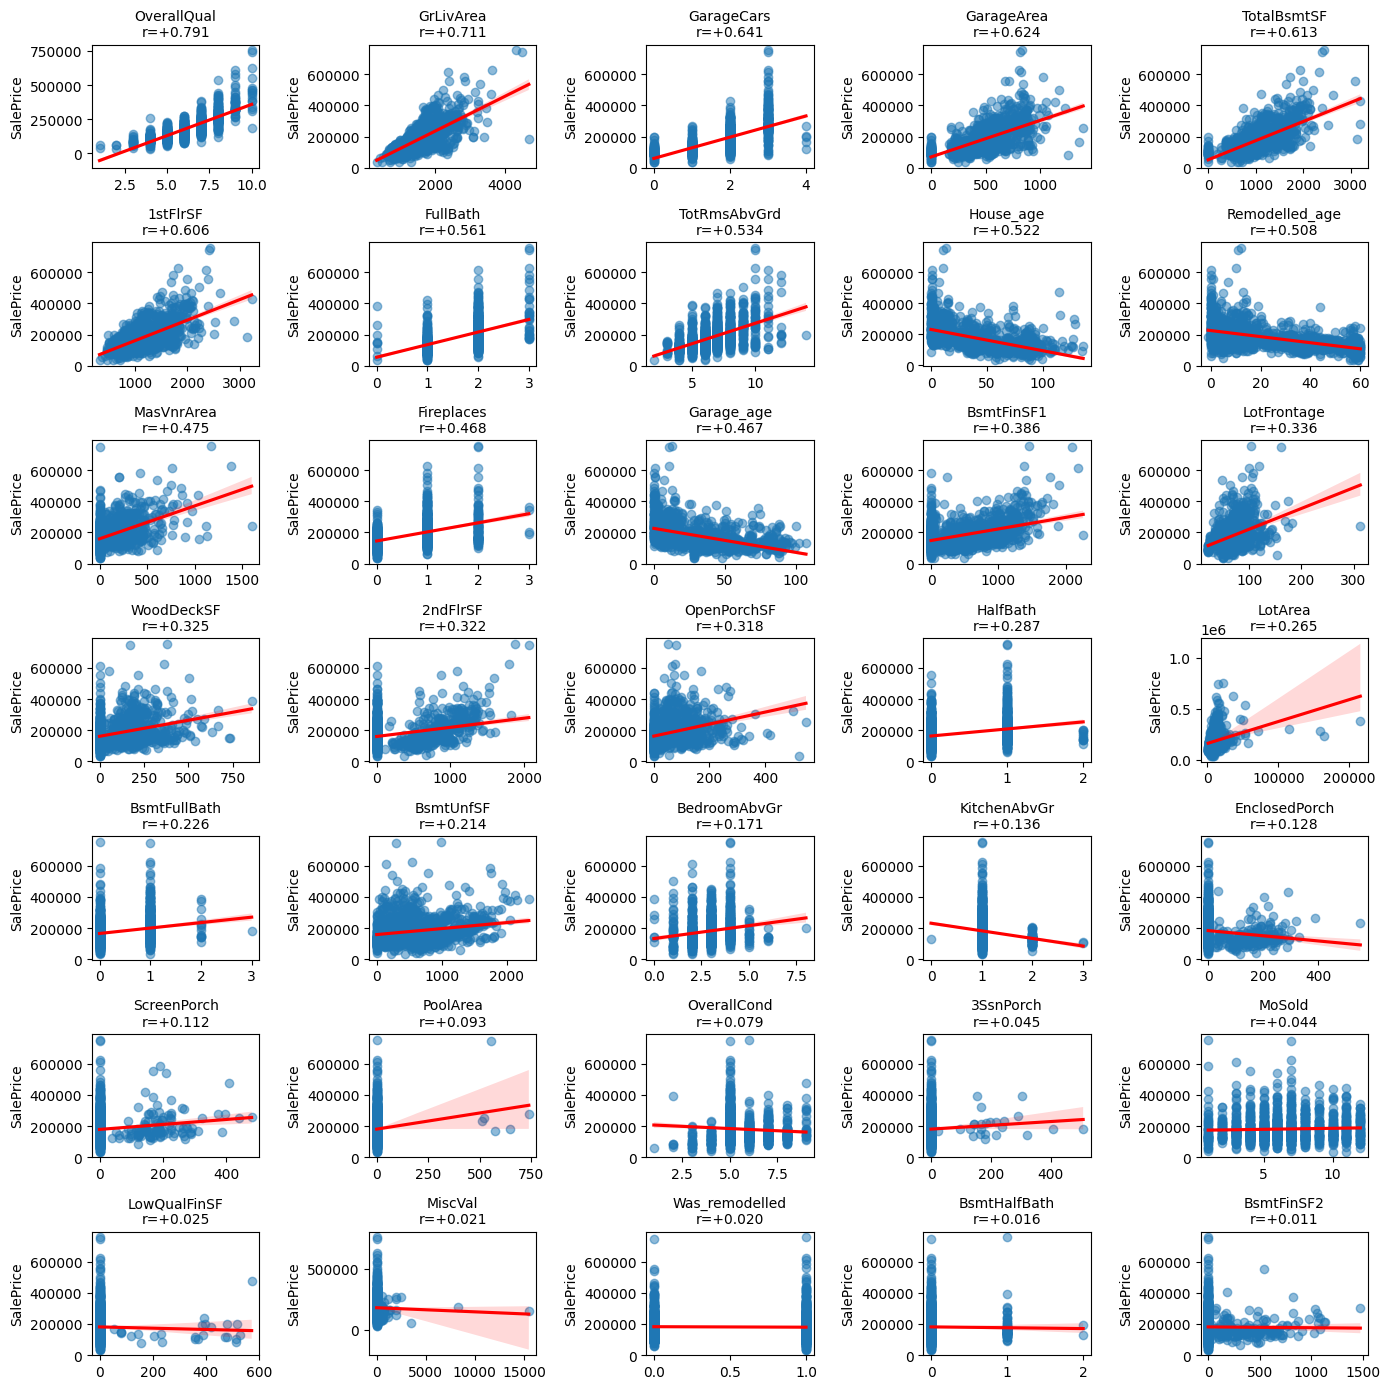

In [31]:
# representation of target as function of feature
fig, axes = plt.subplots(7, 5, figsize= (14,14))
axes = axes.flatten()
for idx, feature in enumerate(target_corr_sorted.index):
    corr_value = target_corr_sorted[feature]
    sns.regplot(x= data_exp[feature], y= data_exp["SalePrice"], ax=axes[idx], scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
    axes[idx].set_title(f"{feature}\nr={corr_value:+.3f}", fontsize=10)
    axes[idx].set_xlabel("")
plt.tight_layout()


#### Conclusion on relationship between numerical features and target

- Numerical features exhibit **both positive and negative correlations** with SalePrice, with most showing clear directional relationships.
- **Strong positive associations:** OverallQual (r=+0.791), GrLivArea (r=+0.709), GarageCars/GarageArea, TotalBsmtSF — larger/better quality features consistently predict higher prices, though some display **non-linear patterns** (OverallQual shows accelerating returns, with steeper price increases at higher quality levels).
- **Moderate associations:** YearBuilt, YearRemodAdd, FullBath — positive trends with considerable scatter, suggesting these contribute but are not deterministic alone.
- **Weak or absent associations:** LowQualFinSF, BsmtHalfBath, EnclosedPorch, 3SsnPorch (r≈0) — minimal predictive power, likely candidates for removal or transformation.
- **Interesting patterns:** LotFrontage and LotArea show **bimodal or segmented patterns** suggesting possible interaction effects with other features (e.g., location or zoning) — these may benefit from feature engineering (binning or interaction terms).
- **Linearity:** While most relationships appear reasonably linear (justifying log transformations for skewed features), several (OverallQual, YearBuilt) show **slight curvature** that tree-based models will capture better than linear models.


### How cardinal features impact Sale Price

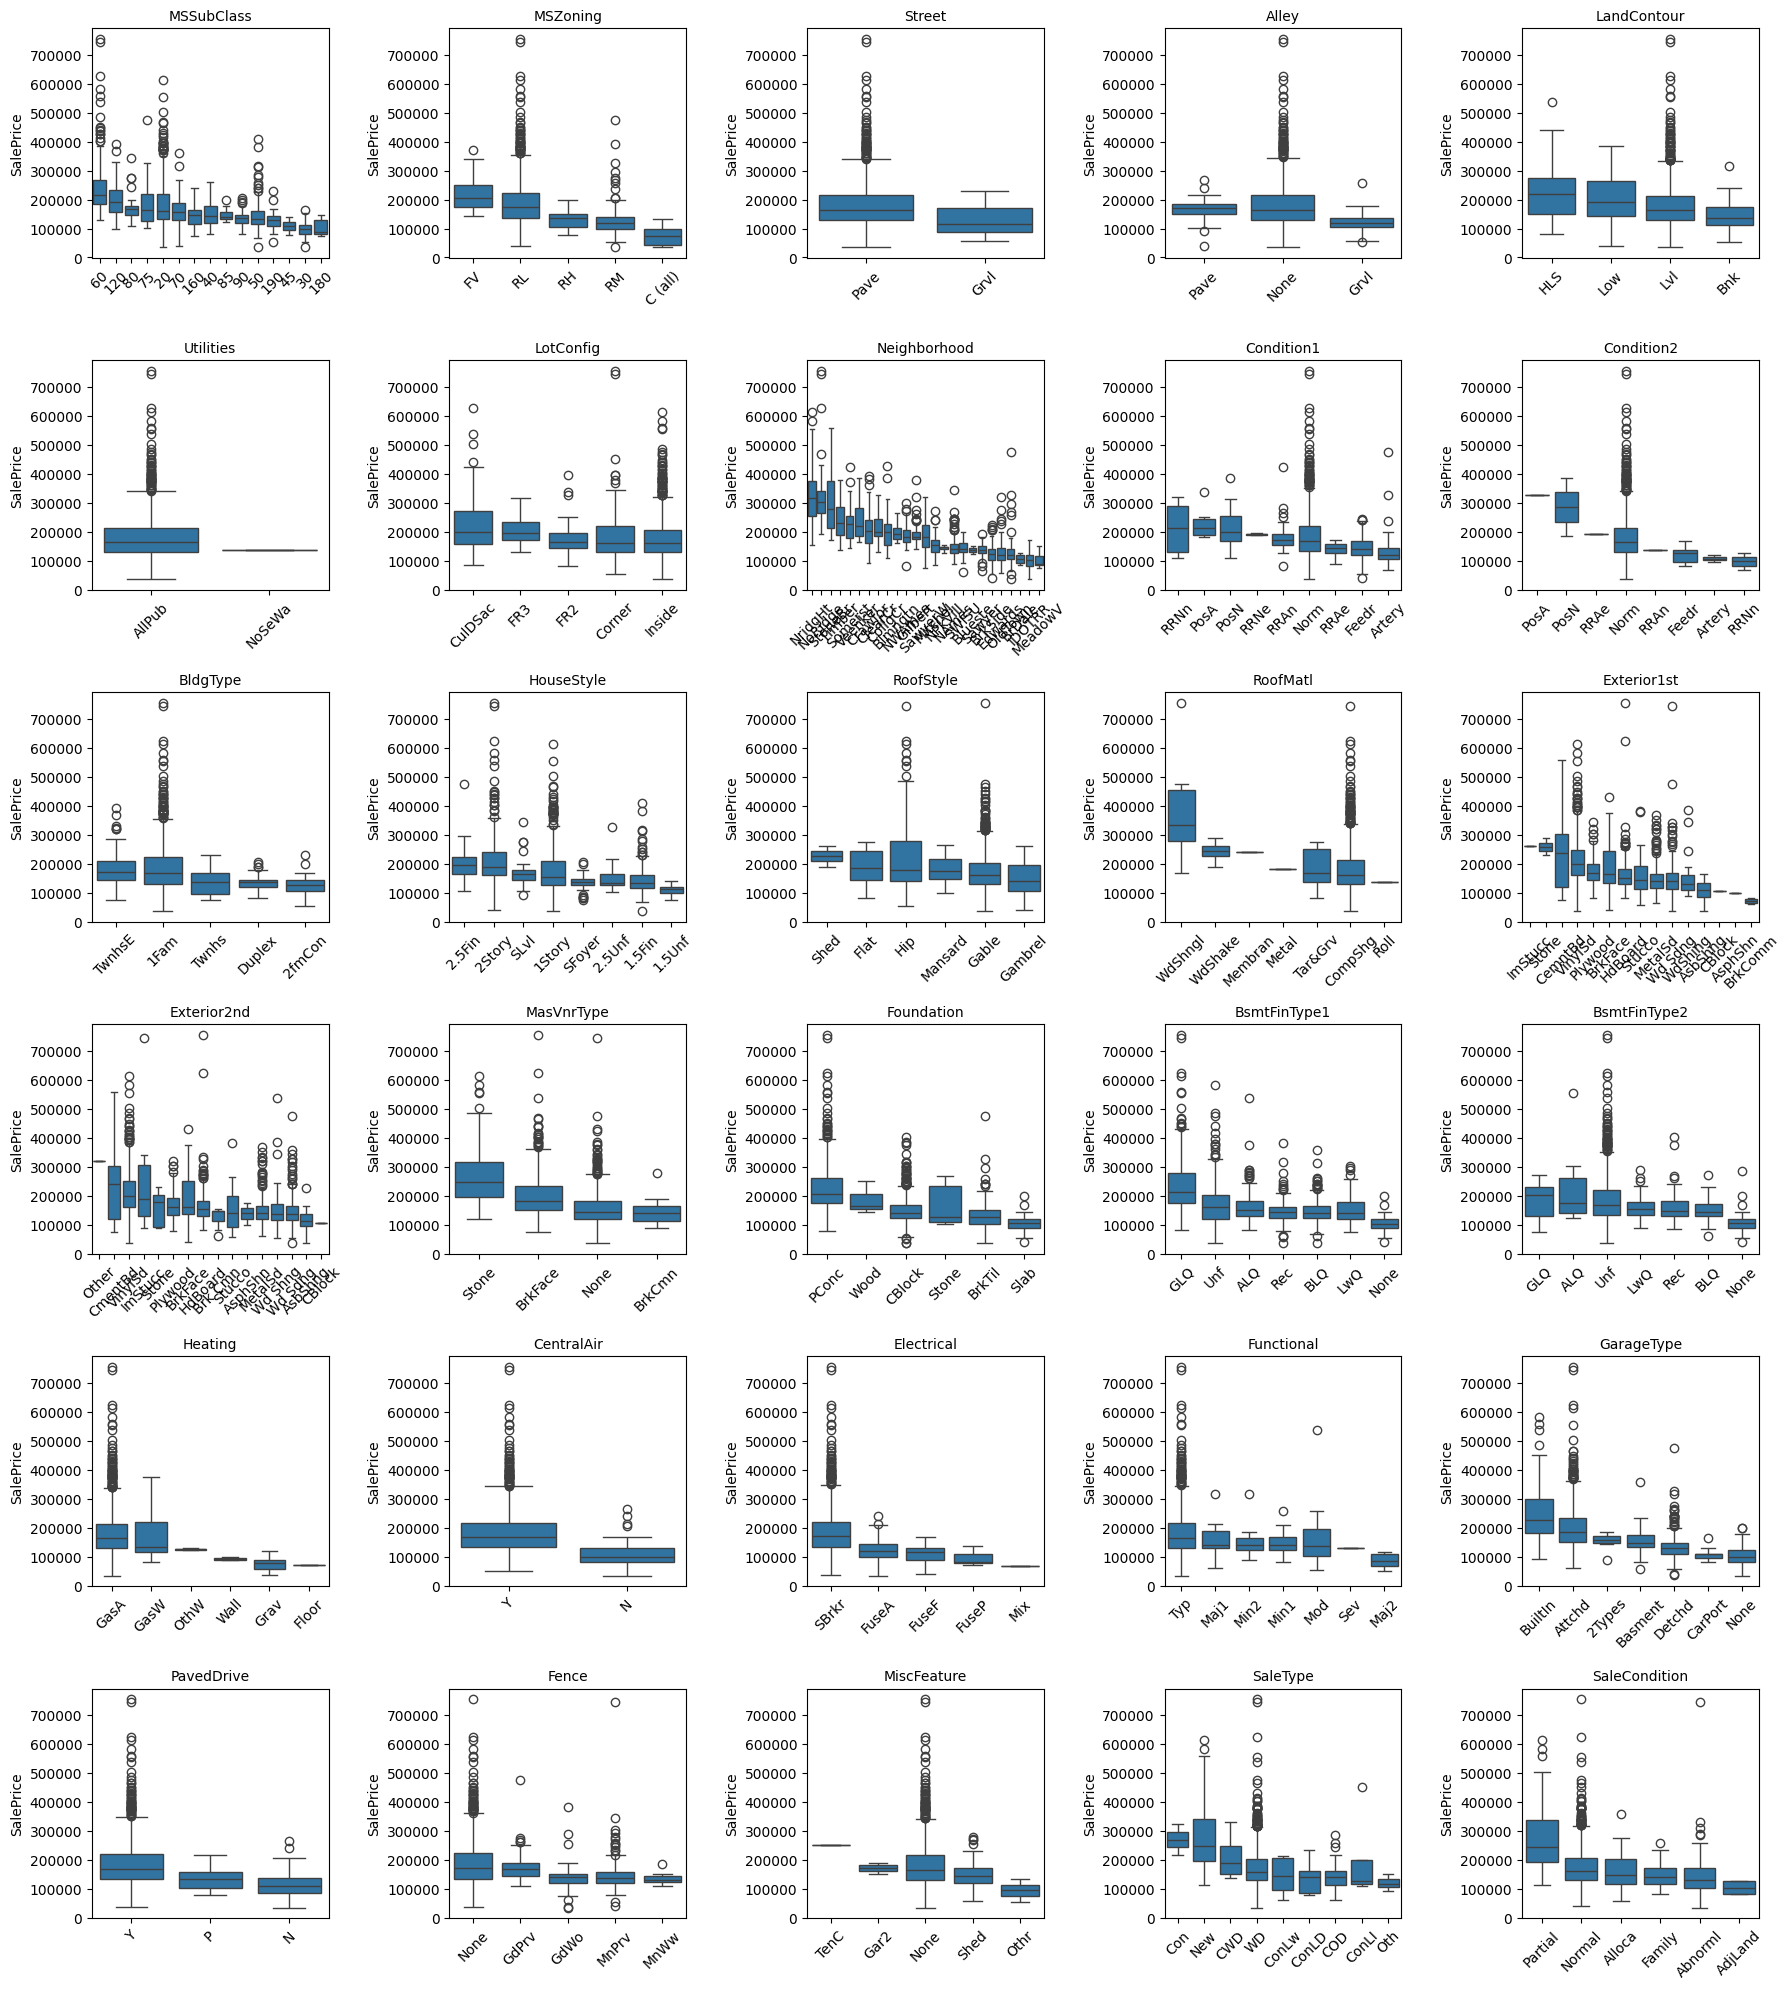

In [37]:
fig, axes = plt.subplots(6,5, figsize=(18,20))
axes = axes.flatten()
for idx, feature in enumerate(cardinal_df.columns):
    median_order = (data_exp.groupby(feature)['SalePrice']
                    .median()
                    .sort_values(ascending=False)
                    .index
                    .tolist())
    sns.boxplot(x= data_exp[feature], y= data_exp["SalePrice"], ax=axes[idx], order=median_order)
    axes[idx].set_title(f"{feature}", fontsize= 10)
    axes[idx].set_xlabel("")
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()


#### Conclusion on relationship between cardinal categorical features and target
- Nominal categorical features show **varying degrees of association** with SalePrice, though most exhibit considerable within-category variability.
- **Strongest associations:** Neighborhood, MSZoning, MasVnrType, SaleType, SaleCondition — clear differences in median price across categories, suggesting these capture important market segments.
- **Weaker or negligible impact:** Fence, RoofStyle, Alley, Utilities — minimal price differentiation between categories, likely candidates for feature selection filtering.
- **Key insight:** High-cardinality features (Neighborhood, Exterior types) will benefit from target encoding to capture price signals while avoiding dimensionality explosion.
- **Variability:** Even strong features show significant overlap between categories, indicating that price is determined by multiple factors acting in combination rather than single categorical features alone. 

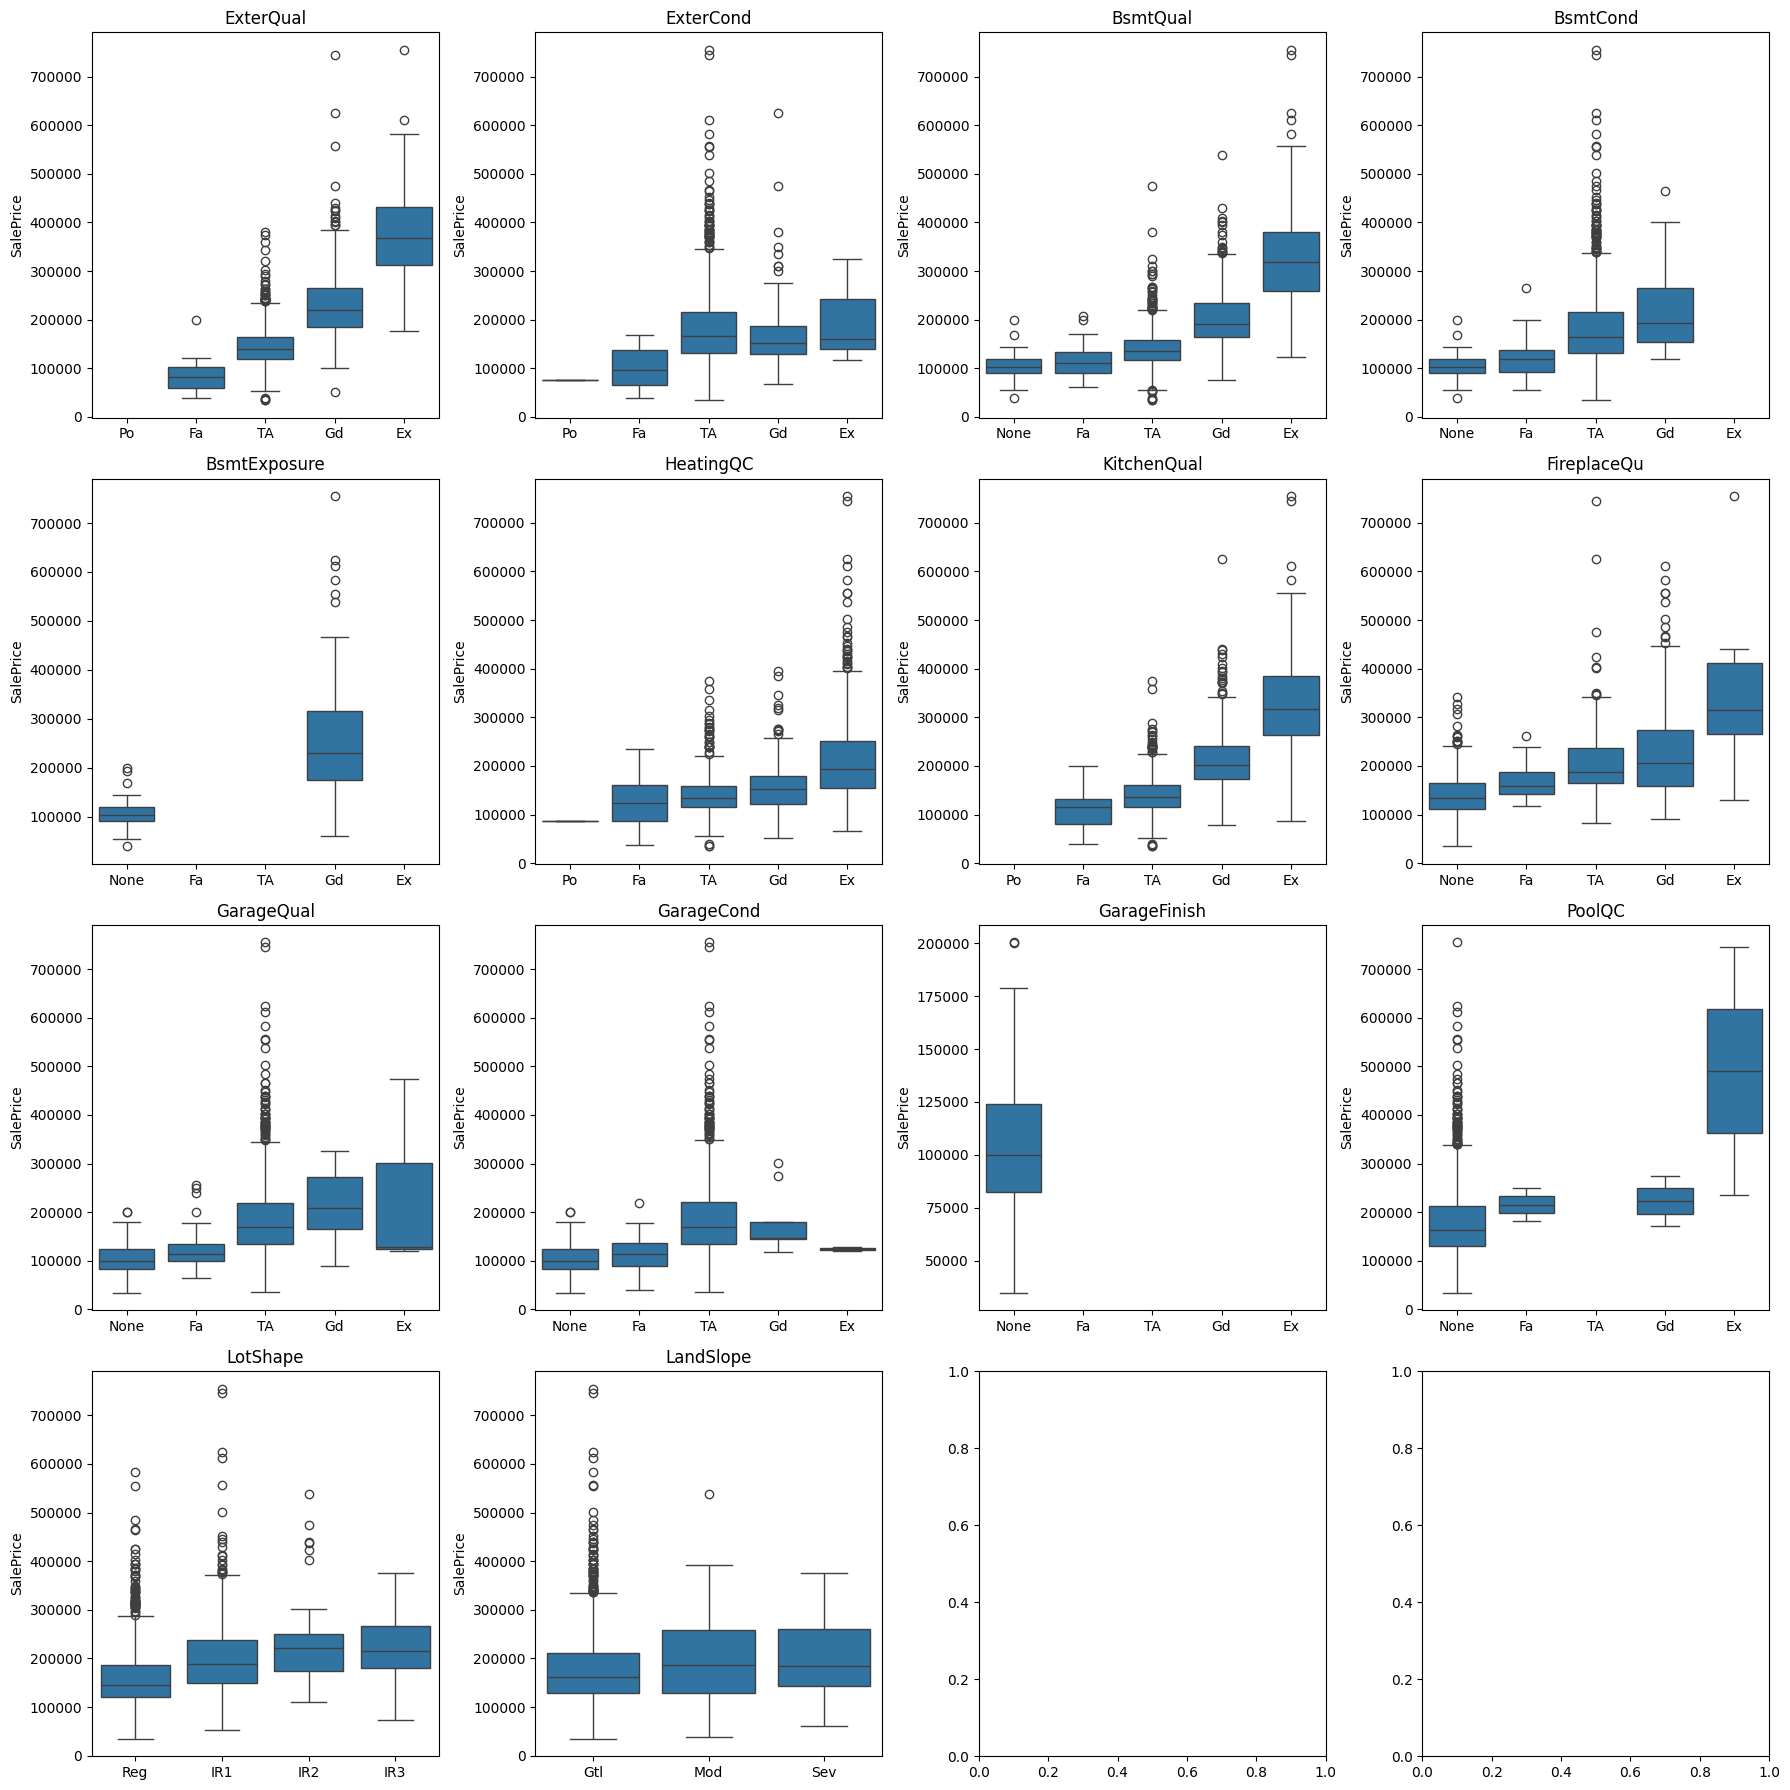

In [ ]:
fig, axes = plt.subplots(4,4, figsize=(18,18))

axes = axes.flatten()
for idx, feature in enumerate(to_ordinal):

    if feature in ['ExterQual','KitchenQual', 'ExterCond', 'HeatingQC']:
        order = ['Po', 'Fa', 'TA', 'Gd', 'Ex']

    elif feature in ['BsmtQual',
            'BsmtCond',
            'BsmtExposure',
            'GarageQual',
            'GarageCond',
            'GarageFinish',
            'FireplaceQu',
            'PoolQC']:
        order= ['None', 'Fa', 'TA', 'Gd', 'Ex']

    else:
        order= None

    sns.boxplot(x= data_exp[feature], y= data_exp["SalePrice"], ax = axes[idx], order= order)
    axes[idx].set_title(f"{feature}")
    axes[idx].set_xlabel("")

plt.tight_layout()


#### Conclusion on relationship between ordinal categorical features and target
- Unsurprisingly, ordinal quality/condition features show **strong monotonic relationships** with SalePrice: higher quality → higher price across the board.
- **Strongest associations:** OverallQual, KitchenQual, ExterQual, BsmtQual — clear step-wise increase in median price with each quality level.
- **Weaker but consistent:** GarageCond, HeatingQC, BsmtCond — pattern is visible but with more variability and overlap between adjacent categories.
- **Key insight:** The ordinal encoding will be highly beneficial as it preserves this natural ordering that models can exploit.
- **Outliers:** Some lower-quality categories still have high-price outliers, suggesting other features (location, size) can compensate for quality deficiencies. 

🧪 Test your code below (and clear the cell once it passed)

## 1.2 Baseline Pipe

### a) Preprocessing

❓ Let's code the basic preprocessing pipeline described below. Save it under `preproc_baseline`.

For categorical features:
- Simple-Impute with the most frequent values
- One-Hot Encode features that have less than 7 unique values to start with
- Drop all other features


As for numerical features:
- Simple-Impute with strategy `mean`
- Min-Max Scale


<details>
    <summary>ℹ️ Click here for a pro tip</summary>

If you are confident, you can try Sklearn's shorter-syntax `make_pipeline` or `make_column_transformer` instead of the longer syntax of `Pipeline` or `ColumnTransformer`; also useful if you want to avoid giving names manually to every step.
</details>

In [ ]:
# YOUR CODE HERE

❓ Look at the **shape** of your preprocessed data_expFrame and save it to `shape_preproc_baseline`

In [ ]:
# YOUR CODE HERE

🧪 Test your code below

In [ ]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'preproc_baseline',
    shape=shape_preproc_baseline
)

result.write()
print(result.check())

### b) Add Estimator

❓ Add a simple Decision Tree model to your `preproc_baseline` and store it to `pipe_baseline` variable.

In [ ]:
# YOUR CODE HERE

### c) Cross-Validate

❓ Read the Kaggle [contest evaluation rules](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation). Which performance metric do you need? Is it readily available in Sklearn?

Sadly, it isn't! We will need to create our custom `sklearn.metrics.scorer` object to pass to any cross-validation or Grid Search. The process is described below:


1. Create a scorer called `rmsle` using [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) that can be passed as a value for the `scoring` `kwarg` like so:  
    ```python
    cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle)
    ```
2.  Create its negative counterpart, `rmsle_neg`, which is best when _maximized_; this will come in handy later as `GridSearchCV` always tries to _maximize_ a score 😉
    ```python
    GridSearchCV(pipe_baseline, param_grid=..., cv=5, scoring=rmsle_neg)
    ```

RMSLE formula

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2.}$$

In [ ]:
# YOUR CODE HERE

❓5-fold cross-validate your `pipe_baseline` using this metric to get a first glance at your baseline performance.    

Store your mean score as `score_baseline`

In [ ]:
# YOUR CODE HERE

### d) Predict Baseline

❓ Predict `y_pred_baseline` from the Kaggle `test.csv` data_expset you stored in the `data_exp` folder.

In [ ]:
X_test = pd.read_csv("https://wagon-public-data_expsets.s3.amazonaws.com/houses_test_raw.csv")
X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id'])

# Predict y_pred_baseline
pass  # YOUR CODE HERE

❓ Finally, store your ready-to-submit CSV as `submission_baseline.csv` in the `data_exp` folder. **Carefully read** and understand Kaggle's required format and test it below (you don't need to submit this baseline to Kaggle for now).

In [ ]:
results = pd.concat([X_test_ids, pd.Series(y_pred_baseline, name="SalePrice")], axis=1)
results.head(1)

In [ ]:
# Export to Kaggle format submission in the `data_exp` folder
results.to_csv("data_exp/submission_baseline.csv", header=True, index=False)

🧪 Test your code

In [ ]:
from nbresult import ChallengeResult

tmp = pd.read_csv("data_exp/submission_baseline.csv")

result = ChallengeResult(
    'submission_baseline',
    score_baseline = score_baseline,
    submission_shape = tmp.shape,
    submission_columns = list(tmp.columns),
    submission_dtypes = str(list(tmp.dtypes)),
)

result.write()
print(result.check())

# 🏋️‍♀️ 2. ITERATIONS 

🎉 🎉 Congratulation on having fully pipelined a baseline model! You will see now how much easier it is to iterate and improve performance 🚀

Now, your goal is to improve your prediction and submit it to Kaggle **at least 30 minutes before the Recap ⏳**

We have some suggestions for improvements below: **pick your battles** and **incrementally** improve your pipeline as you see fit!

**Estimators**

- Tree-based ensembles (a must-try today); probably the best suited for problems with many categorical features
- Stacking!
- XGBoost!

**Preprocessing** (once your first ensemble model works)

- **Ordinal Encoding** of categorical features with a hidden notion of order in their values (e.g. "bad", "average", good")
- **Statistical Feature Selection** to remove useless features (avoids overfitting and reduces training time)
- Predict `log(SalePrice)` instead?
- 🤷

## 2.1 Preprocessing Iteration ♲ 
**⚠️ Come back here only after you have iterated on your estimators in section 2.2 ⚠️**

⏩ Collapse me if I'm not in use!

### a) Ordinal Encoding (~1h)

❓ Look at the following feature. Couldn't it be encoded numerically in a wise manner?
```
ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
```

💡 Luckily, the `OrdinalEncoder` and its argument `categories`  allows us to do just that! Check it out below and make sure to understand how this works 👇

In [ ]:
# Define specific order for features
# Note: if you change this order, it will change the output for .transform()
feature_A_sorted_values = ['bad', 'average', 'good']
feature_B_sorted_values = ['dirty', 'clean', 'new']

encoder = OrdinalEncoder(
    categories=[
        feature_A_sorted_values,
        feature_B_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Just some random training data_exp
XX = [
    ['good', 'dirty'],
    ['bad', 'new'],
    ['average', 'clean'],
]

encoder.fit(XX)

encoder.transform([
        ['bad', "dirty"],
        ["average", "clean"],
        ['good', 'new'],
        ['bad', 'oops never seen this label before']
])

❓ **Your turn**: split your categorical preprocessor into

- `preproc_ordinal` to ordinally encode **some features** (of your choice)
- `preproc_nominal` to one-hot encode the other ones


<details>
    <summary>Hints</summary>

- You won't be able to avoid hard-coding names and ordered values of features! Be tidy!
- It's a good practice to sort your features alphabetically to avoid bad surprises
</details>

In [ ]:
# YOUR CODE HERE

### b) Statistical Feature Selection (~30min)

Our goal is to remove the least interesting features to limit overfitting and shorten training time.  

🔥 We will make use of Sklearn's [feature selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) transformers directly in your pipeline!

❗️ We recommend you try **only Option 1 today**, to start with. Options 2 and 3 will be corrected in the Recap!

#### Option 1 (Recommended) - <font color=green>Univariate</font> Feature Selection
*based on their mutual information with target `y`*

- Feel free to add a `SelectPercentile` filter at the end of your `preproc` pipeline.
- This will filter out features that, taken individually, least explain your target!
- The statistical test we recommend passing to SelectPercentile is the `mutual_info_regression`

<details>
    <summary markdown='span'>🤔 What is mutual information? Click here!</summary>

- [Mutual Information](https://en.wikipedia.org/wiki/Mutual_information) is a **statistical** distance between two probability distributions
- Correlation is a **linear** distance between two random variables
- Mutual Information is more general and measures the reduction of uncertainty in Y after observing X.
- On the other hand, if you already know you are working with variables that are smooth (like continuous numerical variables), sometimes correlation may tell you more about them, for instance if their relationship is monotonic.

See [this animation](https://twitter.com/ari_seff/status/1409296508634152964)
</details>

In [ ]:
# YOUR CODE HERE

#### Option 2 - <font color=green>Multivariate</font> Feature Selection
*based on their combined relationship with target `y`*

🤔 We want to remove features that do not help predict our target even when combined with all the others.

1️⃣ To do so, remember that we can use the [`permutation_importance`](https://scikit-learn.org/stable/modules/permutation_importance.html) metric in combination with an estimator! It trains one pipe per feature to estimate which feature makes our performance score *decrease* the most when shuffling it randomly. These would be our most important features, which we don't want to remove.

The best thing is that `scikit-learn` allows you to integrate this methodology directly into your `preproc` pipeline thanks to the [`SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) transformer; this will recursively remove the least important features according to the `cross_val_score`.

When you have many features, however, this process can take extremely long to train.

2️⃣ Alternatively, a faster way would be to make use of models that already output some measure of `feature_importance` when being fitted. For instance, trees with a Gini-based `feature_importance_`, or Lasso regressions with an L1 `coef_`. `scikit-learn` already has the [`SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) transformer to do just that.

In [ ]:
# YOUR CODE HERE

#### Option 3 - <font color=green>Unsupervised</font> Selection?
*filter based only on the properties of `X`*

❓ A quick win is to remove features with the lowest variance. Think about it: a feature that only has one value is useless (and has a variance of 0).

Feel free to add a [`VarianceThreshold`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) to the end of your pipeline!

In [ ]:
# YOUR CODE HERE

❓ Additionally, we can check for correlation between our **numerical features** only

- Use [Pearson's correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) combined with a heatmap to visually check whether any **numerical** features almost entirely correlate with others
- Use `VIF` from `statsmodels` to check for features that have the highest multicollinearity

In [ ]:
# YOUR CODE HERE

❓ For **ordinal features**, we can use [Spearman's rank correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) instead to check whether some **ordinally encoded** features are almost entirely "ordered" similarly to others. Feel free to plot a heatmap again.

In [ ]:
# YOUR CODE HERE

❓ Now, feel free to create a "filter" in your pipeline that removes any feature you want beyond a given (Spearman + Pearson) correlation threshold; you'll need a custom transformer class.

In [ ]:
# YOUR CODE HERE

### c) Treat Cyclical Features

❓ We have some time-based features, why not **transform them** into cyclical features?

🔎 If you want to know more about why and how we do this, go back to the `Preprocessing Workflow` challenge of the `Prepare the data_expset` unit.

In [ ]:
# YOUR CODE HERE

### d) Target Engineering (~15min)

❓ We are asked to minimize the RMS**L**E. Why don't we transform our target to directly predict its `log`?
- Check out the histogram of the target `y`
- Normally distributed variables should be easier to predict with linear or parametric models
- Create `y_log` and your new performance metrics
- Don't forget to take the exponent of your predictions at the end!

In [ ]:
# YOUR CODE HERE

## 2.2 Model Iteration ♻

#### a) Final Version of the Preproc Pipeline
❓We advise you to start with a fresh definition of your preprocessing pipeline below. Copy-paste from your existing code above.

This way you can quickly update it as needed and then try many model types to find the best one possible. You can try GridSearch (this could take a lot of time) or go model by model.

You can try one or more of the different models you learned in the previous units, and today. 

👉 Your goals:

  - **Try at least one linear model**
  
  - **Try at least one of the tree-based models** you discovered in this unit.

  - Compare the **cross-validated** scores of your different models.

  - It's also interesting to **compare how long it takes** to cross-validate the different models. 🔎 Add the `%%time` magic command as the first line of a notebook cell to time the execution of the cell.

In [ ]:
# YOUR CODE HERE

# 🏅FINAL SUBMISSION (submit at least 30 min before Recap)

It is time to discover your real test score by submitting to Kaggle! 

👉 Follow and complete the next steps to see how good your model is!

In [ ]:
X_test = pd.read_csv("https://wagon-public-data_expsets.s3.amazonaws.com/houses_test_raw.csv")

X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id'])

If you ran the optional cyclical feature treatment in 2.1, you will need to run the following cell to add the extra columns before you feed X_test into your pipeline.

In [ ]:
# If needed, add cyclical feature columns to X_test like we did to X
if 'months_in_a_year' in locals():
    # months_in_a_year is defined, so we need to add the cyclical features
    X_test['sin_MoSold'] = np.sin(2 * np.pi * (X_test.MoSold - 1) / months_in_a_year)
    X_test['cos_MoSold'] = np.cos(2 * np.pi * (X_test.MoSold - 1) / months_in_a_year)

    X_test.drop(columns=['MoSold'], inplace=True)

👉 Predict using your best estimator, and store the results in `predictions`.

In [ ]:
# YOUR CODE HERE

👉 Run the following cells to prepare your predictions to submit to Kaggle.

In [ ]:
# Create a data_expFrame in the correct format
results = pd.concat([X_test_ids, pd.Series(predictions, name="SalePrice")], axis=1)
results

In [ ]:
# Export to Kaggle format submission
results.to_csv("submission_final.csv", header=True, index=False)

👉 Go to Kaggle and submit your predictions. What is your test score? Compare it to the validation scores you obtained.

👉 Write down your test score on the [result spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0) (pick the correct batch!)